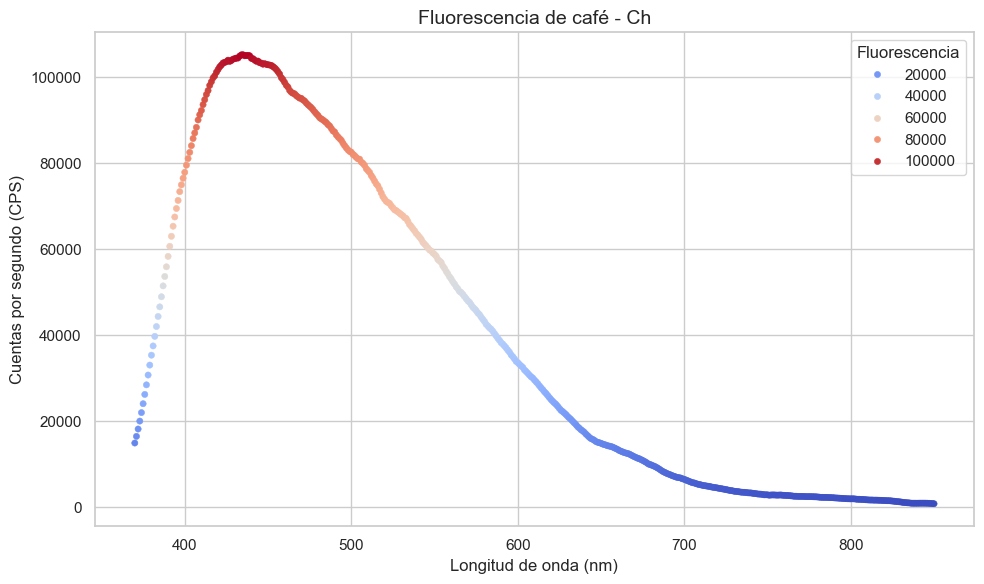

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.signal import savgol_filter

# Leer el archivo (ajusta el nombre si es necesario)
datos = pd.read_csv("FMi_data.csv")

# Convertir la columna 'A' a tipo numérico, forzando errores como NaN
datos["CPS"] = pd.to_numeric(datos["CPS"], errors='coerce')

# Eliminar filas con NaN (por ejemplo, donde 'A' era 'XXX.XXX')
datos = datos.dropna(subset=["CPS"])

# Aplicar suavizado Savitzky-Golay
datos["CPS_suave"] = savgol_filter(datos["CPS"], window_length=19, polyorder=3)

# Configurar estilo
sb.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Gráfica con gradiente de color
sb.scatterplot(
    x="nm", 
    y="CPS_suave", 
    data=datos, 
    hue="CPS_suave", 
    palette="coolwarm", 
    s=20, 
    edgecolor=None
)

# Etiquetas
plt.title("Fluorescencia de café - Ch", fontsize=14)
plt.xlabel("Longitud de onda (nm)")
plt.ylabel("Cuentas por segundo (CPS)", fontsize=12)
plt.legend(title="Fluorescencia", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()